# Projet 5 : Modélisation

**Objectif :** trouver le modèle le plus efficace pour remplir la mission donnée par Olist, segmentez sa base clients pour séparer les "bons" clients des "mauvais".

**Résultat** : le meilleur modèle est le Kmeans avec les données RFM et les hyperparamètres suivant ('init': 'k-means++', 'n_clusters': 4, 'n_init': 10).

## Import des librairies et création des fonctions

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno
from scipy.stats import skew
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples, homogeneity_score, adjusted_rand_score
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.metrics import make_scorer
from math import pi
import warnings
import datetime

# Définir la taille de police par défaut
plt.rcParams.update({'font.size': 14})


Objectif : créer une fonction de scoring pour la gridsearchCV.

In [2]:
def silhouette_scorer(estimator, X):
    """
    Calcule le score silhouette pour les clusters prédits par l'estimateur.

    Parameters:
    estimator (object): L'estimateur de clustering.
    X (array-like): Les données à clusteriser.
    """
    labels = estimator.fit_predict(X)
    return silhouette_score(X, labels)

In [3]:
rfm_df = pd.read_csv("D:/OpenClassroom/Projet_5/RFM_data.csv")

## DBSCAN

Objectif : obtenir les meilleurs paramètres de ce modèle et le comparer au kmeans.

   eps  min_samples  n_clusters  silhouette_score  homogeneity_score
0  0.6            5           7          0.410719           0.040138
1  0.6           10           6          0.410622           0.040103
2  0.6           20           5          0.407783           0.039939
3  0.8            5           7          0.411908           0.040070
4  0.8           10           6          0.411769           0.040076
5  0.8           20           6          0.410845           0.040121
6  1.0            5           6          0.412839           0.039699
7  1.0           10           5          0.413045           0.039702
8  1.0           20           5          0.412817           0.039793

Meilleurs paramètres basés sur le score silhouette:
eps                   1.000000
min_samples          10.000000
n_clusters            5.000000
silhouette_score      0.413045
homogeneity_score     0.039702
Name: 7, dtype: float64

Meilleurs paramètres basés sur le score d'homogénéité:
eps                  0

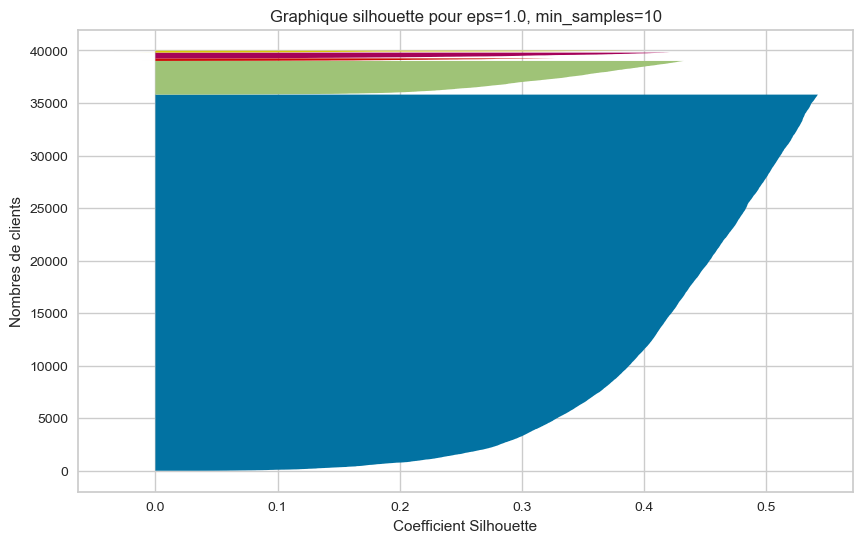

In [4]:
# Sélection des colonnes d'intérêt
columns_of_interest = ['customer_id', 'recency', 'monetary', 'frequency']
data_for_clustering = rfm_df[columns_of_interest].copy()
data_for_clustering_final = data_for_clustering.drop(['customer_id'], axis=1)

# Scaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_for_clustering_final)

# Échantillon aléatoire de 40 000 lignes
data_scaled_df = pd.DataFrame(data_scaled, columns=data_for_clustering_final.columns)
data_for_db = data_scaled_df.sample(n=min(40000, len(data_scaled_df)), random_state=42)

# Définir une grille de paramètres
param_grid = {
    'eps': [0.6, 0.8, 1.0],
    'min_samples': [5, 10, 20]
}

# Initialisation des listes de résultats
results = []

# Combinaisons de paramètres
grid = ParameterGrid(param_grid)

# Boucle sur chaque combinaison de paramètres
for params in grid:
    # DBSCAN
    dbscan = DBSCAN(eps=params['eps'], min_samples=params['min_samples'])

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        labels = dbscan.fit_predict(data_for_db)

    # Calcul du nombre de clusters
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    # Calcul du score silhouette et d'homogénéité
    if n_clusters > 1:
        silhouette = silhouette_score(data_for_db, labels)
        homogeneity = homogeneity_score(data_for_db.index, labels)
    else:
        silhouette = -1
        homogeneity = -1

    # Stockage des résultats
    results.append({
        'eps': params['eps'],
        'min_samples': params['min_samples'],
        'n_clusters': n_clusters,
        'silhouette_score': silhouette,
        'homogeneity_score': homogeneity
    })

# Conversion des résultats en DataFrame
results_df = pd.DataFrame(results)

# Afficher les résultats
print(results_df)

# Meilleurs paramètres basés sur le score silhouette
best_params_silhouette = results_df.loc[results_df['silhouette_score'].idxmax()]
print("\nMeilleurs paramètres basés sur le score silhouette:")
print(best_params_silhouette)

# Meilleurs paramètres basés sur le score d'homogénéité
best_params_homogeneity = results_df.loc[results_df['homogeneity_score'].idxmax()]
print("\nMeilleurs paramètres basés sur le score d'homogénéité:")
print(best_params_homogeneity)

# Utiliser les meilleurs paramètres pour ajuster DBSCAN
best_eps = best_params_silhouette['eps']
best_min_samples = int(best_params_silhouette['min_samples'])

dbscan_best = DBSCAN(eps=best_eps, min_samples=best_min_samples)
labels_best = dbscan_best.fit_predict(data_for_db)

# Filtrer les points de bruit
mask = labels_best != -1
filtered_X = data_for_db[mask]
filtered_labels = labels_best[mask]

# Calculer les scores de silhouette pour chaque point
silhouette_vals = silhouette_samples(filtered_X, filtered_labels)

# Visualiser les silhouettes
fig, ax = plt.subplots(figsize=(10, 6))
y_lower, y_upper = 0, 0
for i in range(len(np.unique(filtered_labels))):
    ith_cluster_silhouette_vals = silhouette_vals[filtered_labels == i]
    ith_cluster_silhouette_vals.sort()
    y_upper += len(ith_cluster_silhouette_vals)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_vals)
    y_lower += len(ith_cluster_silhouette_vals)

ax.set_xlabel('Coefficient Silhouette')
ax.set_ylabel('Nombres de clients')
ax.set_title(f'Graphique silhouette pour eps={best_eps}, min_samples={best_min_samples}')
plt.show()

### Visualisation DBscan

Objectif : obtenir une indication sur la forme des différents clusters.

In [5]:
# Échantillon aléatoire de 50 000 lignes
data_for_db = data_scaled_df.sample(n=min(50000, len(data_scaled_df)), random_state=42)

# DBSCAN
dbscan = DBSCAN(eps=1, min_samples=10)
dbscan.fit(data_for_db)
data_for_db['cluster'] = dbscan.labels_

# Obtention du nombre d'individus dans chaque cluster
cluster_counts = data_for_db['cluster'].value_counts()
print("Nombre d'individus dans chaque cluster:")
print(cluster_counts)


Nombre d'individus dans chaque cluster:
cluster
 0    44752
 1     4008
 3      679
 2      307
 4      225
-1       29
Name: count, dtype: int64


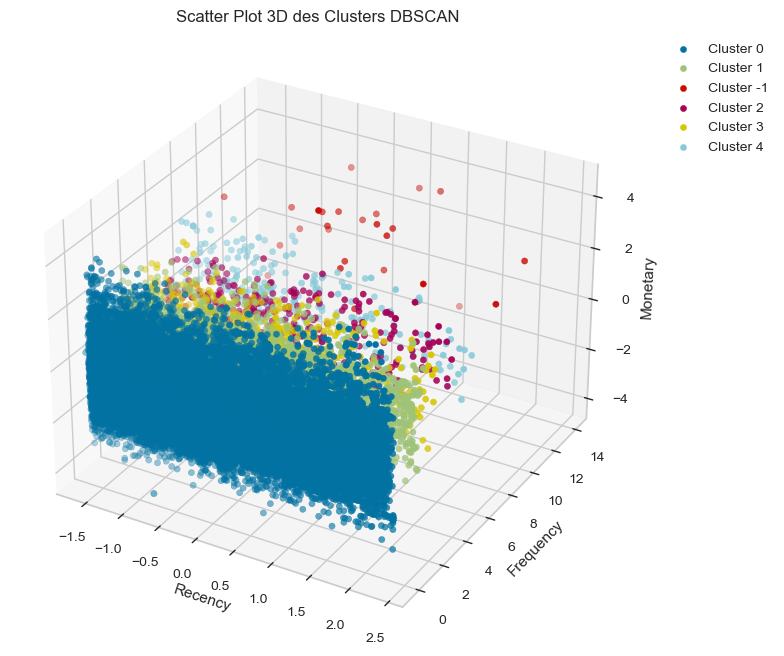

In [6]:
# Visualisation 3D des clusters
fig = plt.figure(figsize=(12, 8))  # Augmenter la taille de la figure
ax = fig.add_subplot(111, projection='3d')

# Séparer les clusters
for cluster in data_for_db['cluster'].unique():
    cluster_data = data_for_db[data_for_db['cluster'] == cluster]
    ax.scatter(cluster_data['recency'], cluster_data['frequency'], cluster_data['monetary'], label=f'Cluster {cluster}')

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

# Ajuster la position de la légende
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

plt.title('Scatter Plot 3D des Clusters DBSCAN')
plt.show()

## Kmeans

Objectif : Trouver les meilleurs paramètres de cet algorithme et le comparer avec le dbscan.

C:\Users\6equal\anaconda3\envs\p5\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\6equal\anaconda3\envs\p5\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\6equal\anaconda3\envs\p5\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\6equal\anaconda3\envs\p5\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 1

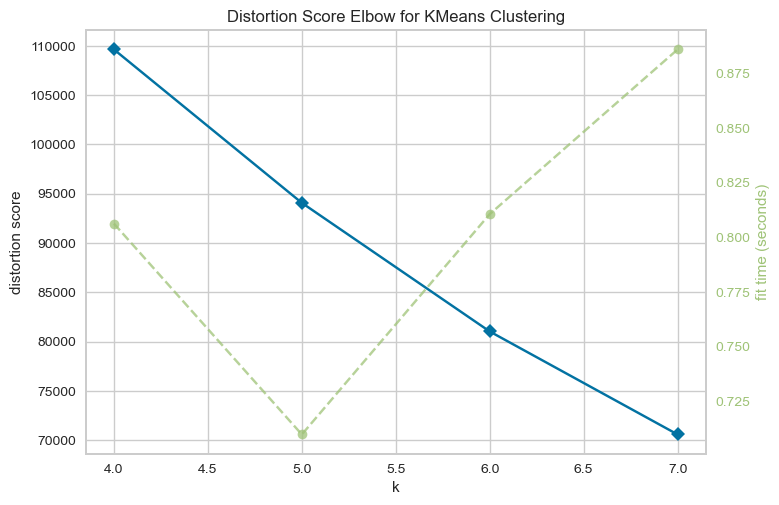

C:\Users\6equal\anaconda3\envs\p5\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\6equal\anaconda3\envs\p5\lib\site-packages\sklearn\model_selection\_validation.py", line 811, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\Users\6equal\anaconda3\envs\p5\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\6equal\anaconda3\envs\p5\lib\site-packages\sklearn\model_selection\_validation.py", line 811, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_tr

Meilleures paramètres :  {'init': 'k-means++', 'n_clusters': 4, 'n_init': 10}


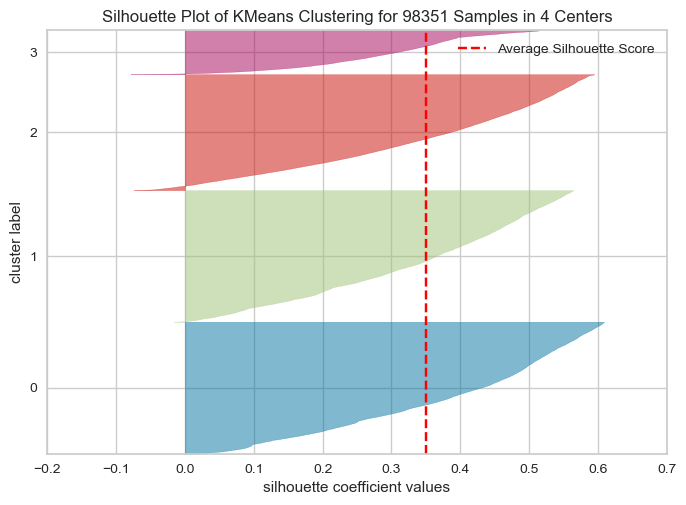

Le score silhouette pour le meilleur modèle est 0.3502
Le score d'homogénéité pour le meilleur modèle est 0.1145
Nombre d'individus dans chaque cluster:
cluster
0    30659
1    30556
2    26939
3    10197
Name: count, dtype: int64


In [7]:
# Sélection des colonnes d'intérêt
columns_of_interest = ['customer_id', 'recency', 'monetary', 'frequency', 'delay', 'average_review_score']
data_for_clustering = rfm_df[columns_of_interest].copy()
data_for_clustering_final = data_for_clustering.drop(['customer_id', 'delay', 'average_review_score'], axis=1)

# Scaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_for_clustering_final)

# Initialisation des valeurs de K
K_range = range(4, 8)

# Visualisation Elbow
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=K_range, timings=True)
visualizer.fit(data_scaled)
visualizer.show()

# Fonction de score pour GridSearch
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    return silhouette_score(X, labels)

# Paramètres à tester dans la GridSearch
param_grid = {
    'n_clusters': K_range,
    'init': ['k-means++', 'random'],
    'n_init': [10, 20]
}

# Initialisation de l'algorithme KMeans
kmeans = KMeans(random_state=42)

# Utilisation de GridSearchCV pour trouver les meilleurs hyperparamètres
grid_search = GridSearchCV(kmeans, param_grid, scoring=make_scorer(silhouette_scorer), cv=5)
grid_search.fit(data_scaled)

# Meilleurs paramètres
print("Meilleures paramètres : ", grid_search.best_params_)

# Meilleur modèle KMeans avec les meilleurs hyperparamètres
best_kmeans = grid_search.best_estimator_

# Visualisation Silhouette
visualizer = SilhouetteVisualizer(best_kmeans, colors='yellowbrick')
visualizer.fit(data_scaled)
visualizer.show()

# Calcul du score silhouette et d'homogénéité
best_silhouette_score = silhouette_score(data_scaled, best_kmeans.labels_)
best_homogeneity_score = homogeneity_score(data_for_clustering_final.index, best_kmeans.labels_)

print(f"Le score silhouette pour le meilleur modèle est {best_silhouette_score:.4f}")
print(f"Le score d'homogénéité pour le meilleur modèle est {best_homogeneity_score:.4f}")

# Attribution des étiquettes de cluster
data_for_clustering['cluster'] = best_kmeans.labels_

# Obtention du nombre d'individus dans chaque cluster
cluster_counts = data_for_clustering['cluster'].value_counts()
print("Nombre d'individus dans chaque cluster:")
print(cluster_counts)

### Kmeans meilleure paramètres

Objectif : Le kmeans étant meilleur que le DBscan nous allons l'exécuter pour visualiser les différents clusters.

In [8]:
# Initialisation du KMeans avec 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)

# Effectuer le clustering
kmeans.fit(data_scaled)

# Ajouter l'inertie du modèle à la liste
inertia = [kmeans.inertia_]

# Assigner les labels de clusters aux données
data_for_clustering['cluster'] = kmeans.labels_

# Compter le nombre d'individus dans chaque cluster
cluster_counts = data_for_clustering['cluster'].value_counts()

# Afficher les résultats
print("Nombre d'individus dans chaque cluster:")
print(cluster_counts)

Nombre d'individus dans chaque cluster:
cluster
0    30659
1    30556
2    26939
3    10197
Name: count, dtype: int64


### Visualisation des cluster

Objectif : visualiser les données caractérisants les différents clusters.

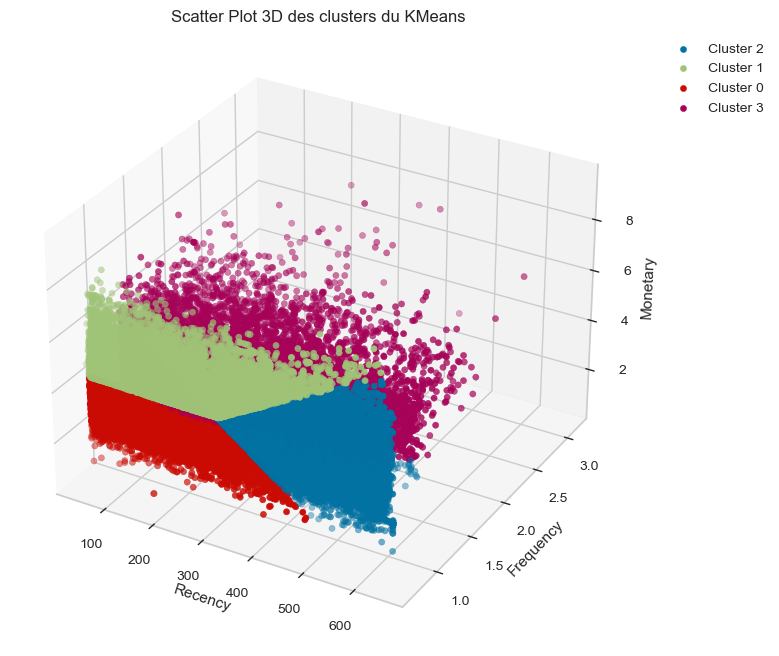

In [9]:
# Visualisation 3D des clusters
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Séparer les clusters
for cluster in data_for_clustering['cluster'].unique():
    cluster_data = data_for_clustering[data_for_clustering['cluster'] == cluster]
    ax.scatter(cluster_data['recency'], cluster_data['frequency'], cluster_data['monetary'], label=f'Cluster {cluster}')

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

# Ajuster la position de la légende
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

plt.title('Scatter Plot 3D des clusters du KMeans')
plt.show()

## Caractéristiques des clusters du Kmeans

### Boxplot

Objectif : proposer une visualisation simplifiée sous forme de boxplot de l'impact des variables sur les différents clusters.

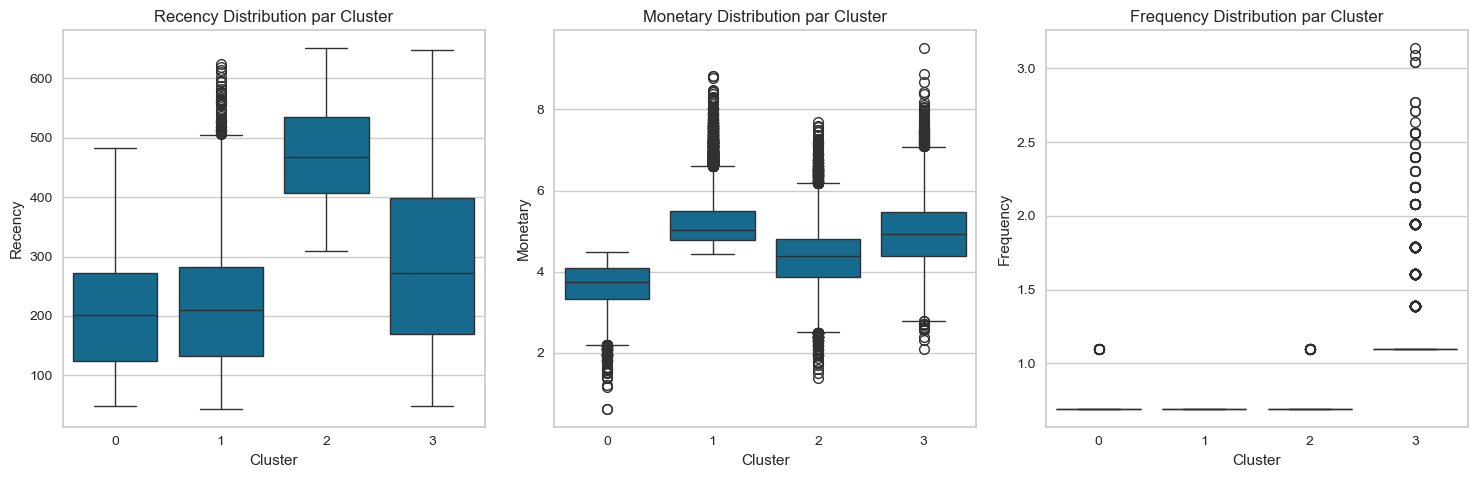

In [10]:
# Box plots pour chaque caractéristique RFM
plt.figure(figsize=(15, 5))
for i, col in enumerate(['recency', 'monetary', 'frequency']):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(x='cluster', y=col, data=data_for_clustering)
    plt.title(f'{col.capitalize()} Distribution par Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(f'{col.capitalize()}')

plt.tight_layout()
plt.show()

### Radar plot

Objectif : proposer une visualisation simplifiée de l'impact des variables sur les différents clusters.

Centroids des clusters:
    recency  frequency  monetary
0 -0.574214  -0.864081 -0.308947
1 -0.504961   0.817653 -0.310033
2  1.213621  -0.139064 -0.308012
3  0.016650   0.518499  2.671646


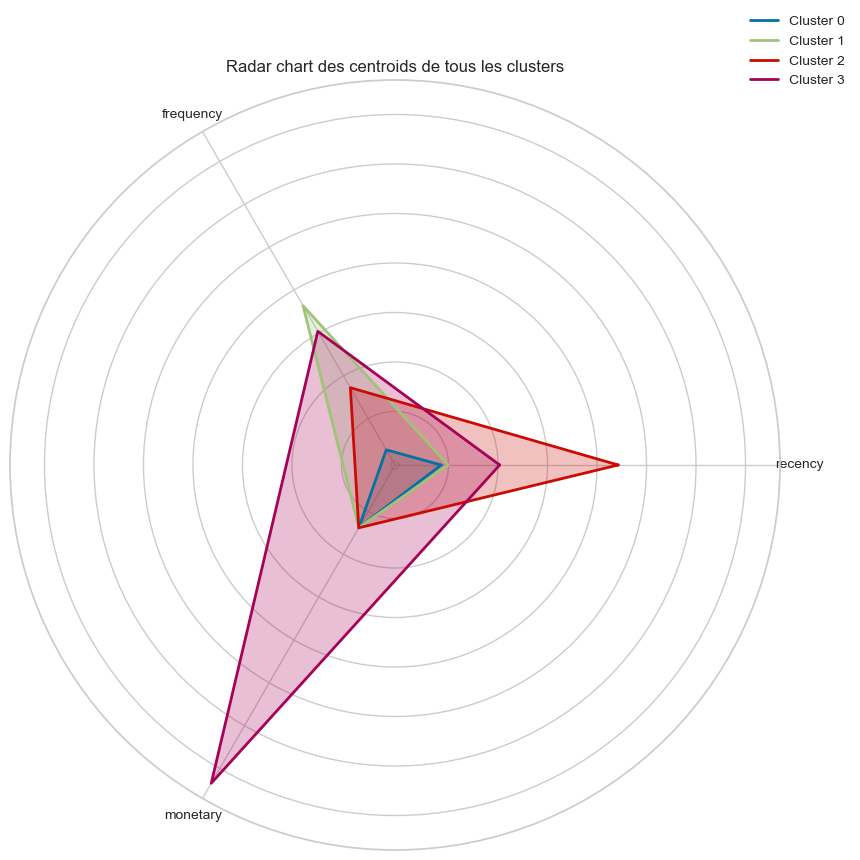

In [11]:
# Obtenir les centroids des clusters
cluster_centroids = pd.DataFrame(kmeans.cluster_centers_, columns=['recency', 'frequency', 'monetary'])

# Afficher les centroids des clusters
print("Centroids des clusters:")
print(cluster_centroids)

# Nombre de clusters
num_clusters = len(cluster_centroids)

# Angles du radar chart
angles = np.linspace(0, 2 * np.pi, len(cluster_centroids.columns), endpoint=False).tolist()
angles += angles[:1]

# Créer un radar chart pour tous les clusters
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

for i in range(num_clusters):
    values = cluster_centroids.iloc[i].tolist()
    values += values[:1]

    ax.plot(angles, values, linewidth=2, linestyle='solid', label=f'Cluster {i}')
    ax.fill(angles, values, alpha=0.25)

# Ajouter les étiquettes des axes
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(cluster_centroids.columns)

plt.title('Radar chart des centroids de tous les clusters')
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.show()

### Kmeans RFM + review

Objectif : le kmeans ayant présenté de meilleur résultat que le dbscan nous allons l'utiliser en ajoutant au variables précédente la notion de temps de livraison et d'avis clients.

C:\Users\6equal\anaconda3\envs\p5\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\6equal\anaconda3\envs\p5\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\6equal\anaconda3\envs\p5\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\6equal\anaconda3\envs\p5\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 1

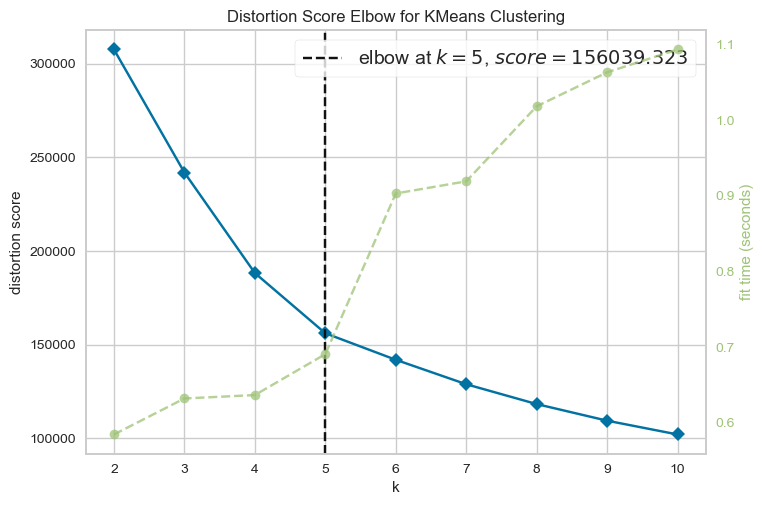

C:\Users\6equal\anaconda3\envs\p5\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\6equal\anaconda3\envs\p5\lib\site-packages\sklearn\model_selection\_validation.py", line 811, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\Users\6equal\anaconda3\envs\p5\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\6equal\anaconda3\envs\p5\lib\site-packages\sklearn\model_selection\_validation.py", line 811, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_tr

Best parameters found:  {'init': 'k-means++', 'n_clusters': 4, 'n_init': 10}


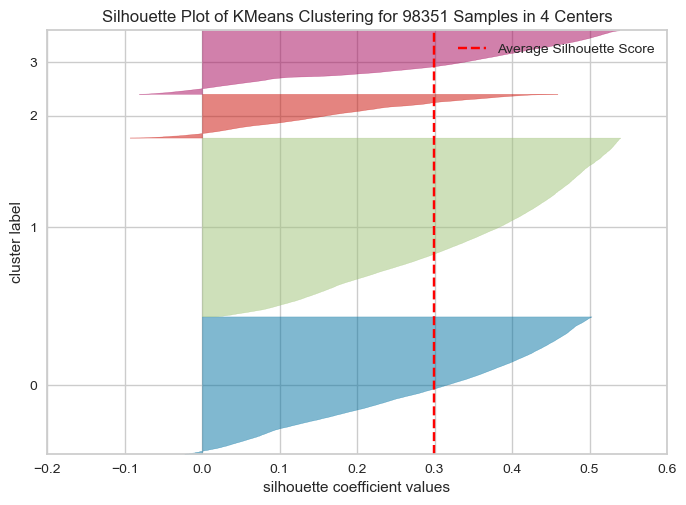

Le score silhouette pour le meilleur modèle est 0.2996
Nombre d'individus dans chaque cluster:
cluster
1    41540
0    31891
3    14765
2    10155
Name: count, dtype: int64


In [12]:
# Sélectionner les colonnes d'intérêt
columns_of_interest = ['customer_id', 'recency', 'monetary', 'frequency', 'average_review_score']
data_for_clustering = rfm_df[columns_of_interest].copy()

# Scaler
scaler = StandardScaler()
data_scaled_kmeans = scaler.fit_transform(data_for_clustering.drop(['customer_id'], axis=1))

# Visualisation Elbow
visualizer = KElbowVisualizer(KMeans(), timings=True)
visualizer.fit(data_scaled_kmeans)
visualizer.show()

# Paramètres de la GridSearch
param_grid = {
    'n_clusters': range(4, 8),
    'init': ['k-means++', 'random'],
    'n_init': [10, 20]
}

# Initialiser KMeans
kmeans = KMeans(random_state=42)

# Utilisation de GridSearchCV pour trouver les meilleurs hyperparamètres
grid_search = GridSearchCV(kmeans, param_grid, scoring=make_scorer(silhouette_scorer), cv=5)
grid_search.fit(data_scaled_kmeans)

# Afficher les meilleurs paramètres trouvés
print("Best parameters found: ", grid_search.best_params_)

# Modèle KMeans avec les meilleurs hyperparamètres
best_kmeans = grid_search.best_estimator_

# Visualisation Silhouette pour le meilleur modèle
visualizer = SilhouetteVisualizer(best_kmeans, colors='yellowbrick')
visualizer.fit(data_scaled_kmeans)
visualizer.show()

# Calcul du score silhouette pour le meilleur modèle
best_score = silhouette_score(data_scaled_kmeans, best_kmeans.labels_)
print(f"Le score silhouette pour le meilleur modèle est {best_score:.4f}")

# Attribuer les étiquettes de cluster au DataFrame originel
data_for_clustering['cluster'] = best_kmeans.labels_

# Afficher le nombre d'individus dans chaque cluster
cluster_counts = data_for_clustering['cluster'].value_counts()
print("Nombre d'individus dans chaque cluster:")
print(cluster_counts)


### radar plot

Objectif : proposer une visualisation simplifiée de l'impact des variables sur les différents clusters.

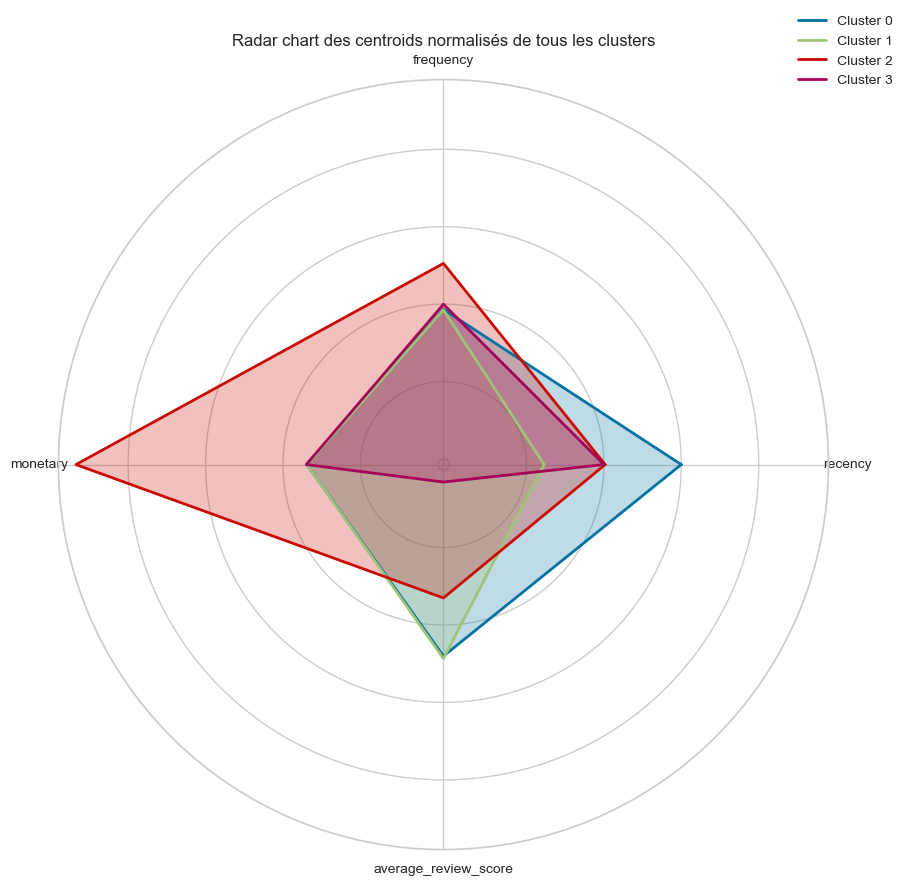

In [13]:
# Obtenir les centroids des clusters du meilleur modèle
cluster_centroids_review = pd.DataFrame(best_kmeans.cluster_centers_, columns=['recency', 'frequency', 'monetary', 'average_review_score'])

# Angles pour le radar chart
angles = np.linspace(0, 2 * np.pi, len(cluster_centroids_review.columns), endpoint=False).tolist()
angles += angles[:1]

# Créer un radar chart pour tous les clusters
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

for i in range(num_clusters):
    values = cluster_centroids_review.iloc[i].tolist()
    values += values[:1]

    ax.plot(angles, values, linewidth=2, linestyle='solid', label=f'Cluster {i}')
    ax.fill(angles, values, alpha=0.25)

# Ajout des étiquettes des axes
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(cluster_centroids_review.columns)

plt.title('Radar chart des centroids normalisés de tous les clusters')
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.show()

## Kmeans full variables

C:\Users\6equal\anaconda3\envs\p5\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\6equal\anaconda3\envs\p5\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\6equal\anaconda3\envs\p5\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\6equal\anaconda3\envs\p5\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 1

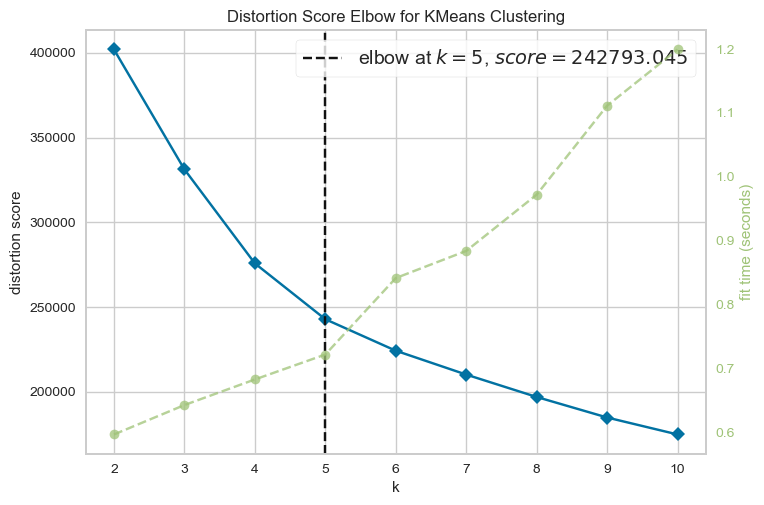

C:\Users\6equal\anaconda3\envs\p5\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\6equal\anaconda3\envs\p5\lib\site-packages\sklearn\model_selection\_validation.py", line 811, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\Users\6equal\anaconda3\envs\p5\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\6equal\anaconda3\envs\p5\lib\site-packages\sklearn\model_selection\_validation.py", line 811, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_tr

Best parameters found:  {'init': 'k-means++', 'n_clusters': 4, 'n_init': 10}


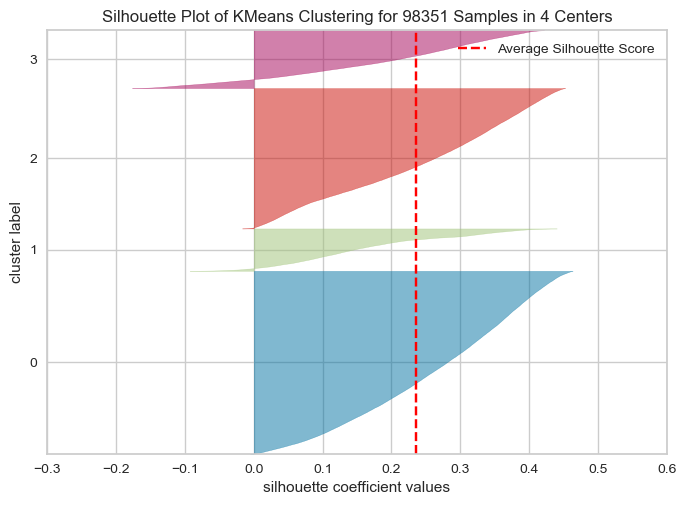

Le score silhouette pour le meilleur modèle est 0.2361
Nombre d'individus dans chaque cluster:
cluster
0    42479
2    32604
3    13424
1     9844
Name: count, dtype: int64


In [14]:
# Sélectionner les colonnes d'intérêt
columns_of_interest = ['customer_id', 'recency', 'monetary', 'frequency', 'delay', 'average_review_score']
data_for_clustering = rfm_df[columns_of_interest].copy()

# Scaler les données
scaler = StandardScaler()
data_scaled_kmeans = scaler.fit_transform(data_for_clustering.drop(['customer_id'], axis=1))

# Visualisation Elbow pour déterminer le nombre optimal de clusters
visualizer = KElbowVisualizer(KMeans(), timings=True)
visualizer.fit(data_scaled_kmeans)
visualizer.show()

# Paramètres de la GridSearch
param_grid = {
    'n_clusters': range(4, 8),
    'init': ['k-means++', 'random'],
    'n_init': [10, 20]
}

# Initialisation de KMeans
kmeans = KMeans(random_state=42)

# Utilisation de GridSearchCV pour trouver les meilleurs hyperparamètres
grid_search = GridSearchCV(kmeans, param_grid, scoring=make_scorer(silhouette_scorer), cv=5)
grid_search.fit(data_scaled_kmeans)

# Afficher les meilleurs paramètres trouvés
print("Best parameters found: ", grid_search.best_params_)

# Modèle KMeans avec les meilleurs hyperparamètres
best_kmeans = grid_search.best_estimator_

# Visualisation Silhouette pour le meilleur modèle
visualizer = SilhouetteVisualizer(best_kmeans, colors='yellowbrick')
visualizer.fit(data_scaled_kmeans)
visualizer.show()

# Calcul du score silhouette pour le meilleur modèle
best_score = silhouette_score(data_scaled_kmeans, best_kmeans.labels_)
print(f"Le score silhouette pour le meilleur modèle est {best_score:.4f}")

# Attribuer les étiquettes de cluster au DataFrame originel
data_for_clustering['cluster'] = best_kmeans.labels_

# Afficher le nombre d'individus dans chaque cluster
cluster_counts = data_for_clustering['cluster'].value_counts()
print("Nombre d'individus dans chaque cluster:")
print(cluster_counts)


### Radar plot sur l'ensemble des variables

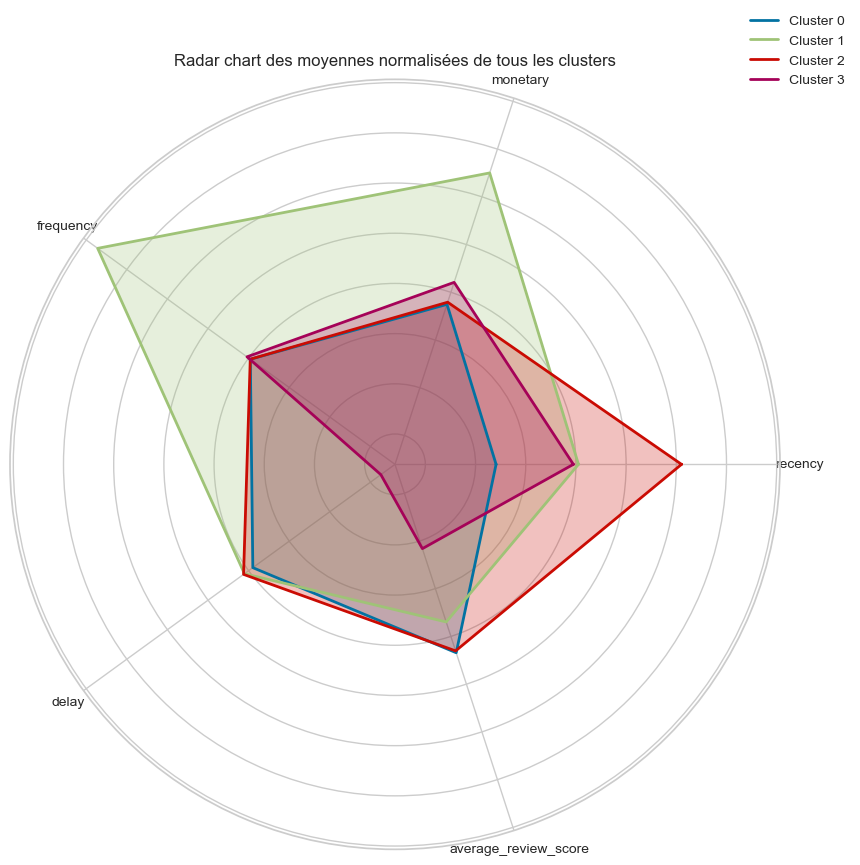

In [15]:
# Groupby sur les clusters et calcul de la moyenne
cluster_means_full = data_for_clustering.groupby('cluster')[['recency', 'monetary', 'frequency', 'delay', 'average_review_score']].mean()

# Normalisation des valeurs pour le graphique radar
scaler = RobustScaler()
cluster_means_full_normalized = pd.DataFrame(scaler.fit_transform(cluster_means_full), columns=cluster_means_full.columns)

# Nombre de clusters
num_clusters = len(cluster_means_full_normalized)

# Angles pour le radar chart
angles = np.linspace(0, 2 * np.pi, len(cluster_means_full_normalized.columns), endpoint=False).tolist()
angles += angles[:1]

# Créer un radar chart pour visualiser les moyennes normalisées de tous les clusters
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

for i in range(num_clusters):
    values = cluster_means_full_normalized.iloc[i].tolist()
    values += values[:1]

    ax.plot(angles, values, linewidth=2, linestyle='solid', label=f'Cluster {i}')
    ax.fill(angles, values, alpha=0.25)

# Ajout des étiquettes des axes
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(cluster_means_full_normalized.columns)

# Ajouter un titre et une légende au radar chart
plt.title('Radar chart des moyennes normalisées de tous les clusters')
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

# Afficher le radar chart
plt.show()

## Stabilité

Objectif : vérifier la stabilité de notre modèle à l'aide de plusieurs itérations de celui-ci.Nous utiliserons les valeurs RFM qui ont présenté de meilleur résultat.

Adjusted Rand Index scores pour chaque itération: [0.484124371784846, 0.9987515287395174, 0.991487284947725, 0.44571161835278034, 0.9997305512935335, 0.9994059808449157, 0.9882651904340484, 0.8237104032653069, 0.9981347212672479]
Moyenne du score ARI : 0.8588
Silhouette scores pour chaque itération: [0.35013969168383274, 0.3022034175528797, 0.35016468285756946, 0.35023150157133054, 0.3515016415868093, 0.3501459769174294, 0.3501493850791632, 0.3502878896713118, 0.31254277488770926, 0.35011280336221073]
Moyenne du score de silhouette : 0.3417


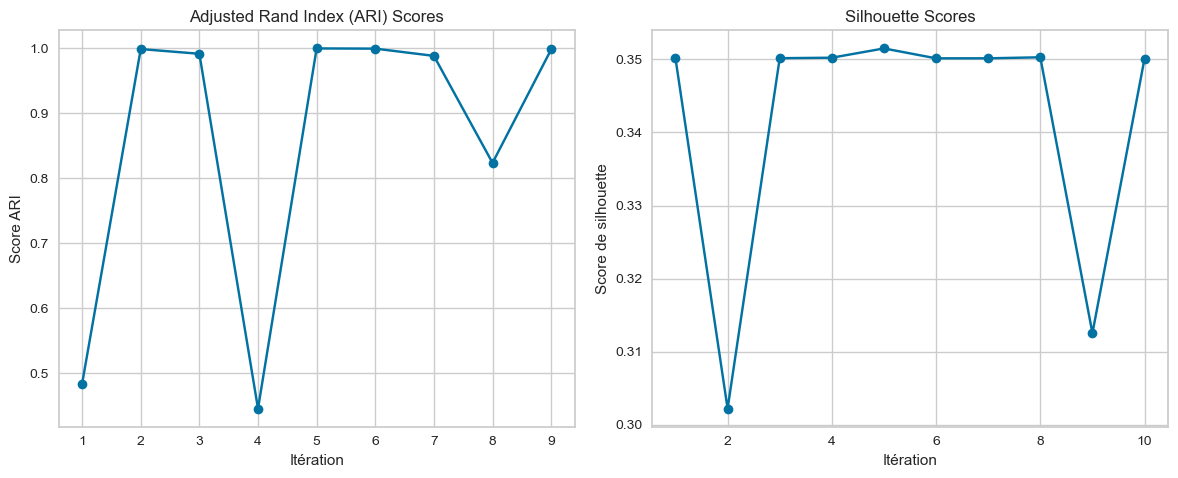

In [18]:
# Listes pour stocker les scores ARI et les scores de silhouette
ari_scores = []
silhouette_scores = []

# Exécutions du KMeans pour évaluer la stabilité
for i in range(10):
    kmeans = KMeans(n_clusters=best_kmeans.n_clusters, init='k-means++', n_init=1, random_state=i)
    kmeans.fit(data_scaled)
    labels = kmeans.labels_

    # Comparaison des labels avec ceux de la première exécution
    if i == 0:
        reference_labels = labels
    else:
        ari = adjusted_rand_score(reference_labels, labels)
        ari_scores.append(ari)

    # Calcul du score de silhouette pour chaque itération
    silhouette_avg = silhouette_score(data_scaled, labels)
    silhouette_scores.append(silhouette_avg)

# Affichage des résultats
print("Adjusted Rand Index scores pour chaque itération:", ari_scores)
print(f"Moyenne du score ARI : {np.mean(ari_scores):.4f}")
print("Silhouette scores pour chaque itération:", silhouette_scores)
print(f"Moyenne du score de silhouette : {np.mean(silhouette_scores):.4f}")

# Création du graphique pour les scores ARI
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, 10), ari_scores, marker='o', linestyle='-')
plt.title('Adjusted Rand Index (ARI) Scores')
plt.xlabel('Itération')
plt.ylabel('Score ARI')
plt.grid(True)

# Création du graphique pour les scores de silhouette
plt.subplot(1, 2, 2)
plt.plot(range(1, 11), silhouette_scores, marker='o', linestyle='-')
plt.title('Silhouette Scores')
plt.xlabel('Itération')
plt.ylabel('Score de silhouette')
plt.grid(True)

plt.tight_layout()
plt.show()